In [15]:
import random as random
import time as time
import heapq as heapq
import matplotlib.pyplot as plt # 画曲线图
import numpy as np #拟合直线

class HyperNode:
    def __init__(self,id,degree,edges):
        self.id = id
        self.degree = degree
        self.edges = edges

    def __lt__(self,other):
        return self.id<other.id
    
    def print(self):
        print("id:" + str(self.id))
        print("degree:" + str(self.degree))
        print("edges: "+ str(self.edges))

class HyperEdge:
    def __init__(self,id,degree,nodes):
        self.id = id
        self.degree = degree 
        self.nodes = nodes
        
    def print(self):
        print("id:" + str(self.id))
        print("degree:" + str(self.degree))
        print("edges: "+ str(self.nodes))

# # return: mp_node,mp_edge
# def load_data(path):
#     # input:
#     # path: data set path
    
#     # return: 
#     # mp_node: dict of partition node n_id:HyperNode
#     # mp_edge: dict of partition edge e_id:HyperEdge
    
#     mp_node = {}
#     mp_edge = {}
#     with open(path,'r') as f:
#         for line in f:
#             if(line[0]=='#' or line=='\n') : continue
#             data = [int(i) for i in line[0:-1].split(" ")]
#             n_id = data[0]
#             n_degree = data[1]
#             n_edges = set(data[2:])
#             if mp_node.get(n_id) == None : 
#                 mp_node[n_id] = HyperNode(n_id,n_degree,n_edges)
#                 tmp[n_id] = HyperNode(n_id,n_degree,n_edges)
#             for edge in n_edges:
#                 if mp_edge.get(edge) == None:
#                     mp_edge[edge] = HyperEdge(edge,0,set())
#                 mp_edge[edge].degree += 1
#                 mp_edge[edge].nodes.add(n_id)
#     return mp_node,mp_edge

# return: mp_node,mp_edge
def load_data(path):
    # input:
    # path: data set path
    
    # return: 
    # mp_node: dict of partition node n_id:HyperNode
    # mp_edge: dict of partition edge e_id:HyperEdge
    
    mp_node = {}
    mp_edge = {}
    with open(path,'r') as f:
        for line in f:
#             print(line[0:-1].split(" "))
            n_id,e_id = line[0:-1].split(" ")
            if mp_node.get(n_id) == None : 
                mp_node[n_id] = HyperNode(n_id,0,set())
            if mp_edge.get(e_id) == None :
                mp_edge[e_id] = HyperEdge(e_id,0,set())
                
            mp_node[n_id].degree += 1
            mp_edge[e_id].degree += 1
            mp_node[n_id].edges.add(e_id)
            mp_edge[e_id].nodes.add(n_id)
    return mp_node,mp_edge

# return: None
def recoder(part_node,mp_node,mp_edge,path):
    # input:
    # part_node: result of partition nodemp_eval[node.id] - node.degree
    # mp_node: dictionary of hyper node 
    # mp_edge: dictionary of hyper edge
    # path: path to save record result
    
    dic = {}
    tot = 0
    for par in part_node:
        for node in par:
            dic[node.id] = len(dic)

    print(path+"/record.txt")
    with open(path+"/record.txt",'w') as f:
        for par in part_node:
            for node in par:
                for edge in node.edges:
                    f.write(str(dic[node.id])+" "+str(edge)+"\n")
# return: part_node,part_edge
class Heap:
    def __init__(self):
        self.heap = []
        self.check = set()
        
    def add(self,rank,item):
        if item in self.check : return
        heapq.heappush(self.heap,(rank,item))
        self.check.add(item)
        
    def pop(self):
        rank,item = heapq.heappop(self.heap)
        self.check.remove(item)
        return rank,item
    
    def clear(self):
        self.check.clear()
        self.heap = []
        
    def check(self,item):
        return item in self.check
    
    def size(self):
#         print(self.heap)
        return len(self.heap)
    
    def top(self):
        return self.heap[0]
    
    def remake(self,ls):
#         print("before:",self.heap)
        heapq.heapify(ls)
        self.heap = ls
#         print("after:",self.heap)
        
def solve(p,mp_node,mp_edge,prop = 1.0,k=1,shield_heavy_edge = 1e9 ,buffer_fac = 5,debug = False):
    # input : 
    # p: partition number 
    # mp_node: dict of partition nodes  
    # mp_edge: dict of partition edges
    # prob: accelerate factory to add node
    # k: select topk node at once
    # shield_heavy_node: filter huge edge 
    # debug: print debug infomation
    
    # return :
    # part_node: list of partition node set 
    # part_edge: list of partition edge set
    
    random.seed(19990320)
    node_number = len(mp_node)
    cur_p = 0
    maxi_cap = node_number/p + 1
    part_node = [set() for i in range(p)]
    part_edge = [set() for i in range(p)]
    mp_eval = {i:0 for i in mp_node.keys()}
    
    ave_hyperedge_degree = 0
    edge_degree_list = set()
    for edge in mp_edge.values():   
        ave_hyperedge_degree += edge.degree/len(mp_edge)
        edge_degree_list.add(edge.degree)
#     print(edge_degree_list)
    edge_degree_list = list(edge_degree_list)
    edge_degree_list.sort()
#     print(edge_degree_list)
#     print(len(mp_edge)/2)
#     print("2*ave:",ave_hyperedge_degree," mid:",edge_degree_list[int(len(edge_degree_list)/2)])
    ave_hyperedge_degree = edge_degree_list[int(len(edge_degree_list)/2)]

    cnt = 0
    select_node = Heap()
    heap_size = buffer_fac*k
    while len(mp_node)!=0:
        cnt += 1
        if cnt % 100 == 0 and debug : print (cnt)
            
        add_node = []
        
        if select_node.size() <= k:
            select_node.clear()
            for node in mp_node.values():   
                if  select_node.size() < heap_size:
                    select_node.add(mp_eval[node.id],node)
                else :
                    if mp_eval[node.id] > select_node.top()[0] :
                        rank,remove_node = select_node.pop()
                        select_node.add(mp_eval[node.id],node)
        
        for i in range(min(k,select_node.size())):
            rank,node = select_node.pop()
            add_node.append(node)

        for par_node in add_node:
            if len(part_node[cur_p]) >= maxi_cap :
                break
            part_node[cur_p].add(par_node)
            for edge in par_node.edges:
                if edge not in part_edge[cur_p]:
                    part_edge[cur_p].add(edge)
                    if mp_edge[edge].degree > shield_heavy_edge: continue
                    for node in mp_edge[edge].nodes:
                        if mp_node.get(node) == None : continue
                        mp_eval[node] += 1
#                         print(len(select_node))
            del mp_node[par_node.id] 
        remake_ls = [(mp_eval[node.id],node) for rank,node in select_node.heap]
#         print(remake_ls)
        select_node.remake(remake_ls)

        if len(part_node[cur_p]) >= maxi_cap : # next partition pre-process
            for key in mp_eval.keys():
                mp_eval[key] = 0
            cur_p += 1   
            
    return part_node,part_edge
        
        
def solve2(p,mp_node,mp_edge,prop = 1.0,k=1,shield_heavy_edge = 1e9 ,buffer_fac = 5,debug = False):
    # input : 
    # p: partition number 
    # mp_node: dict of partition nodes  
    # mp_edge: dict of partition edges
    # prob: accelerate factory to add node
    # k: select topk node at once
    # shield_heavy_node: filter huge edge 
    # debug: print debug infomation
    
    # return :
    # part_node: list of partition node set 
    # part_edge: list of partition edge set
    
    random.seed(19990320)
    node_number = len(mp_node)
    cur_p = 0
    maxi_cap = node_number/p + 1
    part_node = [set() for i in range(p)]
    part_edge = [set() for i in range(p)]
    mp_eval = {i:0 for i in mp_node.keys()}

    cnt = 0
    select_node = Heap()
    heap_size = buffer_fac*k
    
    while len(mp_node)!=0:
        cnt += 1
        if cnt % 100 == 0 and debug : print (cnt)
            
        add_node = []
        
        if select_node.size() <= k:
            select_node.clear()
            for node in mp_node.values(): 
                if mp_eval[node.id] == 0 : 
                    if select_node.size() < heap_size : 
                        select_node.add(-1e9,node)
                    else : continue
                if  select_node.size() < heap_size:
                    select_node.add(mp_eval[node.id] - node.degree,node)
                else :
                    if mp_eval[node.id] - node.degree > select_node.top()[0] :
                        rank,remove_node = select_node.pop()
                        select_node.add(mp_eval[node.id] - node.degree,node)
        
        for i in range(min(k,select_node.size())):
            rank,node = select_node.pop()
            add_node.append(node)

        for par_node in add_node:
            if len(part_node[cur_p]) >= maxi_cap :
                break
            part_node[cur_p].add(par_node)
            for edge in par_node.edges:
                if edge not in part_edge[cur_p]:
                    part_edge[cur_p].add(edge)
                    if mp_edge[edge].degree > shield_heavy_edge: continue
                    for node in mp_edge[edge].nodes:
                        if mp_node.get(node) == None : continue
                        mp_eval[node] += 1
#                         print(len(select_node))
            del mp_node[par_node.id] 
        remake_ls = [(mp_eval[node.id]-node.degree,node)for rank,node in select_node.heap]
        select_node.remake(remake_ls)

        if len(part_node[cur_p]) >= maxi_cap : # next partition pre-process
            for key in mp_eval.keys():
                mp_eval[key] = 0
            cur_p += 1   
            
    return part_node,part_edge



def degree_distribute(mp_node,show = True,logx=True,logy=True,coeff = True,cumulation = True): # draw degree distribute graph 
    degree = mp_node
    dic = {j.degree:0 for i,j in degree.items()}
    
    for i,j in degree.items(): dic[j.degree] += 1
    
    ls = sorted(dic.items(), key = lambda x:(x[0],x[1]))
        
    x = [i[0] for i in ls]
    y = [i[1] for i in ls]

    if x[0] == 0:
        x = x[1:-1]
        y = y[1:-1]
    
    if cumulation == True : 
        cnt = sum(y)
        for i in range(len(x)):
            cnt -= y[i]
            y[i] += cnt

    if show == True :
        plt.plot(x,y, 'o',color='b')
        if logy : plt.yscale('log')
        if logx : plt.xscale('log')
        

    if coeff == True : 

        xx = [np.log2(i) for i in x]
        yy = [np.log2(i) for i in y]
        
        k,b = np.polyfit(xx, yy, 1)
#         lg = yy[0]/xx[-1]
#         lg = 1/lg
        print("alpha: "+str(k))
        
        xx = x
        yy = [(i**k)*(2**b) for i in xx]
        plt.plot(xx,yy,color='r')
    plt.show()

    return [(x[i],y[i]) for i in range(len(x))]


alpha: -1.733355505918805


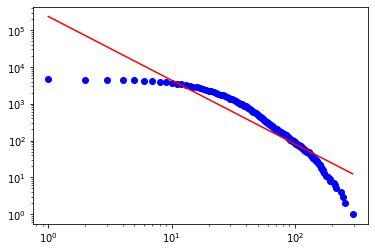

[(0, <__main__.HyperNode object at 0x7f6c41642cf8>), (0, <__main__.HyperNode object at 0x7f6c3fd4fc88>)]
[(1, <__main__.HyperNode object at 0x7f6c3fd4fc88>)]
[(33, <__main__.HyperNode object at 0x7f6c3fee74e0>), (31, <__main__.HyperNode object at 0x7f6c4cf7f780>)]
[(70, <__main__.HyperNode object at 0x7f6c3fee74e0>)]
[(93, <__main__.HyperNode object at 0x7f6c4d3fb898>), (90, <__main__.HyperNode object at 0x7f6c4c365908>)]
[(103, <__main__.HyperNode object at 0x7f6c4d3fb898>)]
[(229, <__main__.HyperNode object at 0x7f6c415ad710>), (236, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(240, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(207, <__main__.HyperNode object at 0x7f6c4dad7d68>), (240, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(242, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(167, <__main__.HyperNode object at 0x7f6c4cf7ec88>), (243, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(170, <__main__.HyperNode 

[(244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(74, <__main__.HyperNode object at 0x7f6c40407f98>), (244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(73, <__main__.HyperNode object at 0x7f6c4052a7b8>), (244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(72, <__main__.HyperNode object at 0x7f6c4cb317b8>), (244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(72, <__main__.HyperNode object at 0x7f6c4cec08d0>), (244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(72, <__main__.HyperNode object at 0x7f6c4d3a0908>), (244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(71, <__main__.HyperNode object at 0x7f6c4e317518>), (244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(244, <__main__.Hyper

[(244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(52, <__main__.HyperNode object at 0x7f6c40b2aeb8>), (244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(51, <__main__.HyperNode object at 0x7f6c4dae9d30>), (244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(51, <__main__.HyperNode object at 0x7f6c4dbd7390>), (244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(51, <__main__.HyperNode object at 0x7f6c4bb2db00>), (244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(51, <__main__.HyperNode object at 0x7f6c4d722c50>), (244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(51, <__main__.HyperNode object at 0x7f6c4bf5b4a8>), (244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(244, <__main__.Hyper

[(244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(45, <__main__.HyperNode object at 0x7f6c4e359be0>), (244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(45, <__main__.HyperNode object at 0x7f6c4c7d76a0>), (244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(45, <__main__.HyperNode object at 0x7f6c4e3d6860>), (244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(45, <__main__.HyperNode object at 0x7f6c4e73ca90>), (244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(45, <__main__.HyperNode object at 0x7f6c4bf53978>), (244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(45, <__main__.HyperNode object at 0x7f6c4b363e10>), (244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(244, <__main__.Hyper

[(244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(40, <__main__.HyperNode object at 0x7f6c4cfb23c8>), (244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(40, <__main__.HyperNode object at 0x7f6c4cb06400>), (244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(40, <__main__.HyperNode object at 0x7f6c4c7ea9b0>), (244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(40, <__main__.HyperNode object at 0x7f6c4163c470>), (244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(40, <__main__.HyperNode object at 0x7f6c4dee0be0>), (244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(40, <__main__.HyperNode object at 0x7f6c4bbb4898>), (244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(244, <__main__.Hyper

[(244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(36, <__main__.HyperNode object at 0x7f6c4db755f8>), (244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(36, <__main__.HyperNode object at 0x7f6c4b760748>), (244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(36, <__main__.HyperNode object at 0x7f6c40d83630>), (244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(36, <__main__.HyperNode object at 0x7f6c4d34cb38>), (244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(36, <__main__.HyperNode object at 0x7f6c40d6ca20>), (244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(36, <__main__.HyperNode object at 0x7f6c40df46d8>), (244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(244, <__main__.Hyper

[(244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(32, <__main__.HyperNode object at 0x7f6c4bf5a208>), (244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(32, <__main__.HyperNode object at 0x7f6c4e6aefd0>), (244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(32, <__main__.HyperNode object at 0x7f6c4184ea58>), (244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(32, <__main__.HyperNode object at 0x7f6c40495898>), (244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(32, <__main__.HyperNode object at 0x7f6c4053c080>), (244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(32, <__main__.HyperNode object at 0x7f6c4053fe10>), (244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(244, <__main__.Hyper

[(29, <__main__.HyperNode object at 0x7f6c4b2b8080>), (244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(29, <__main__.HyperNode object at 0x7f6c4de890b8>), (244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(29, <__main__.HyperNode object at 0x7f6c40a68f98>), (244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(29, <__main__.HyperNode object at 0x7f6c41840c18>), (244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(29, <__main__.HyperNode object at 0x7f6c40477c18>), (244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(29, <__main__.HyperNode object at 0x7f6c405277f0>), (244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(29, <__main__.HyperN

[(244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(25, <__main__.HyperNode object at 0x7f6c4cfd7b38>), (244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(25, <__main__.HyperNode object at 0x7f6c40ab77b8>), (244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(25, <__main__.HyperNode object at 0x7f6c40a907f0>), (244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(24, <__main__.HyperNode object at 0x7f6c4d7129e8>), (244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(24, <__main__.HyperNode object at 0x7f6c4027e6d8>), (244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(24, <__main__.HyperNode object at 0x7f6c4ce47898>), (244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(244, <__main__.Hyper

[(244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(21, <__main__.HyperNode object at 0x7f6c4db83fd0>), (244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(21, <__main__.HyperNode object at 0x7f6c4c39a080>), (244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(21, <__main__.HyperNode object at 0x7f6c4d3c2710>), (244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(21, <__main__.HyperNode object at 0x7f6c4ce76eb8>), (244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(21, <__main__.HyperNode object at 0x7f6c4d7c3908>), (244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(21, <__main__.HyperNode object at 0x7f6c4d2b2c88>), (244, <__main__.HyperNode object at 0x7f6c4bb8af28>)]
[(244, <__main__.Hyper

[(11, <__main__.HyperNode object at 0x7f6c4d7e8278>), (17, <__main__.HyperNode object at 0x7f6c404cd2e8>)]
[(17, <__main__.HyperNode object at 0x7f6c404cd2e8>)]
[(14, <__main__.HyperNode object at 0x7f6c4d293240>), (17, <__main__.HyperNode object at 0x7f6c404cd2e8>)]
[(17, <__main__.HyperNode object at 0x7f6c404cd2e8>)]
[(11, <__main__.HyperNode object at 0x7f6c4db587b8>), (17, <__main__.HyperNode object at 0x7f6c404cd2e8>)]
[(17, <__main__.HyperNode object at 0x7f6c404cd2e8>)]
[(13, <__main__.HyperNode object at 0x7f6c4c319710>), (17, <__main__.HyperNode object at 0x7f6c404cd2e8>)]
[(17, <__main__.HyperNode object at 0x7f6c404cd2e8>)]
[(14, <__main__.HyperNode object at 0x7f6c4c799320>), (17, <__main__.HyperNode object at 0x7f6c404cd2e8>)]
[(17, <__main__.HyperNode object at 0x7f6c404cd2e8>)]
[(12, <__main__.HyperNode object at 0x7f6c40ddb160>), (17, <__main__.HyperNode object at 0x7f6c404cd2e8>)]
[(17, <__main__.HyperNode object at 0x7f6c404cd2e8>)]
[(11, <__main__.HyperNode object a

[(18, <__main__.HyperNode object at 0x7f6c4e6cdf98>)]
[(14, <__main__.HyperNode object at 0x7f6c4d255a20>), (18, <__main__.HyperNode object at 0x7f6c4e6cdf98>)]
[(18, <__main__.HyperNode object at 0x7f6c4e6cdf98>)]
[(14, <__main__.HyperNode object at 0x7f6c4c7d2f28>), (18, <__main__.HyperNode object at 0x7f6c4e6cdf98>)]
[(18, <__main__.HyperNode object at 0x7f6c4e6cdf98>)]
[(14, <__main__.HyperNode object at 0x7f6c4daa7908>), (18, <__main__.HyperNode object at 0x7f6c4e6cdf98>)]
[(18, <__main__.HyperNode object at 0x7f6c4e6cdf98>)]
[(14, <__main__.HyperNode object at 0x7f6c4c358ba8>), (18, <__main__.HyperNode object at 0x7f6c4e6cdf98>)]
[(18, <__main__.HyperNode object at 0x7f6c4e6cdf98>)]
[(13, <__main__.HyperNode object at 0x7f6c4d7a1550>), (18, <__main__.HyperNode object at 0x7f6c4e6cdf98>)]
[(18, <__main__.HyperNode object at 0x7f6c4e6cdf98>)]
[(13, <__main__.HyperNode object at 0x7f6c4bf36d68>), (18, <__main__.HyperNode object at 0x7f6c4e6cdf98>)]
[(18, <__main__.HyperNode object a

KeyboardInterrupt: 

In [16]:
# path = "./data/github/github.txt"
path = "./data/wiki/wiki.txt"
p = 1
mp_node,mp_edge = load_data(path)
ls = degree_distribute(mp_node)
for turn in range(8):
    p*=2
    prop = 1.1
    k = 1
    buffer_fac = 3
    shield_heavy_edge = 1e9
    mp_node,mp_edge = load_data(path)
#     degree_distribute(mp_node)
    time_beg = time.time()
    part_node,part_edge = solve(p,mp_node,mp_edge,prop,k,buffer_fac = buffer_fac,shield_heavy_edge = shield_heavy_edge)  
    time_end = time.time()
    mp_node,mp_edge = load_data(path)
    # recoder(part_node,mp_node,mp_edge,"./data/wiki")
    k_1 = sum([len(i) for i in part_edge]) - len(mp_edge)
#     print(turn," ",k_1)
    print("parameter:\n","p:",p," prop:","%.2f"%prop," k:",k," buffer_fac:",buffer_fac,
          " sheld_size:",shield_heavy_edge)
    print("result1:\n","runtime:",int((time_end-time_beg)*1000),"ms k-1:",k_1)
    mp_node,mp_edge = load_data(path)
#     degree_distribute(mp_node)
    time_beg = time.time()
    part_node,part_edge = solve2(p,mp_node,mp_edge,prop,k,buffer_fac = buffer_fac,shield_heavy_edge = shield_heavy_edge)  
    time_end = time.time()
    mp_node,mp_edge = load_data(path)
    # recoder(part_node,mp_node,mp_edge,"./data/wiki")
    k_1 = sum([len(i) for i in part_edge]) - len(mp_edge)
    print("result2:\n","runtime:",int((time_end-time_beg)*1000),"ms k-1:",k_1)
    print("---------------------------------------")
#  runtime: 11999 ms k-1: 27102
    

alpha: -1.6363240049196743


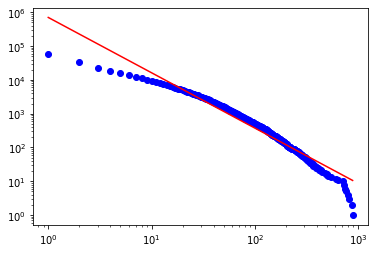

KeyboardInterrupt: 

In [23]:
def test_shield():
    x = []
    y = []
#     path = "./data/wiki/wiki.txt"
    path = "./data/github/github.txt"
    p = 16
    mp_node,mp_edge = load_data(path)
    ls = degree_distribute(mp_node)
    for turn in range(61,81):
    #     p*=2
        mp_node,mp_edge = load_data(path)
    #     degree_distribute(mp_node)
        time_beg = time.time()
        prop = 1.1
        k = 10
        buffer_fac = 1
        shield_heavy_edge = turn
        part_node,part_edge = solve(p,mp_node,mp_edge,prop,k,buffer_fac = buffer_fac,shield_heavy_edge = shield_heavy_edge)  
        time_end = time.time()
        mp_node,mp_edge = load_data(path)
        # recoder(part_node,mp_node,mp_edge,"./data/wiki")
        k_1 = sum([len(i) for i in part_edge]) - len(mp_edge)
#         print(turn," ",k_1)
        x.append(turn)
        y.append(k_1)
    plt.plot(x,y,color='r')
    plt.show()
    return x,y
    
x,y = test_shield()

In [6]:
path = "./data/github/github.txt"
mp_node,mp_edge = load_data(path)
ls = degree_distribute(mp_node)
sum = 0
p60 = 0
p80 = 0
for i,j in ls:
    if i < 60 : p60 += j
    if i < 80 : p80 += j
    sum += j
print(p60/sum*100," ",p80/sum*100)

TypeError: 'int' object is not callable

In [5]:
for i in range(len(x)):
    print(x)

NameError: name 'x' is not defined

In [23]:
tmp_node = [set() for i in range(p)]

for par in range(len(part_edge)):
    for i in part_node[par]: tmp_node[par].add(i.id)
    cnt = 0
    print("edges:"+str(len(part_edge[par])))
    print("nodes:"+str(len(part_node[par])))
    for edge in part_edge[par]:
        for node in mp_edge[edge].nodes:
#             print(node)
#             print(mp_node[node])
            if node in tmp_node[par]:
                cnt += 1
    cur_p += 1
    print(cnt)
    

edges:56433
nodes:5653
277912
edges:25730
nodes:5653
59056
edges:15618
nodes:5653
28610
edges:7641
nodes:5653
14208
edges:7349
nodes:5653
12455
edges:7531
nodes:5653
11444
edges:7756
nodes:5653
10089
edges:8023
nodes:5653
9310
edges:7767
nodes:5653
8748
edges:7984
nodes:5642
8405


In [4]:
k_1 = sum([len(i) for i in part_edge]) - edge_number
print(k_1)

30965
